In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
import nana
from astropy import units as u

In [2]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [3]:
#all times MUST be in days
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) ###frequency resolution in data
sampling_rate= np.median(np.diff(lc.time.value))
print(total_observation_time,sampling_rate)

1470.4622572100852 0.02043360086827306


In [4]:
#4 is prob way too much
f_max = 4*(1 / (sampling_rate))


In [5]:
time_fake = lc.time.value
flux_fake =  1+ 0.01 * np.cos(2 * np.pi * time_fake) + 0.01* np.cos(4 * np.pi * time_fake) + 0.001 * np.random.normal(size=time_fake.shape) #fake flux data


lc_fake = lk.LightCurve(time=time_fake, flux=flux_fake) #light curve will automatically assume 
name_fake = "fake data"


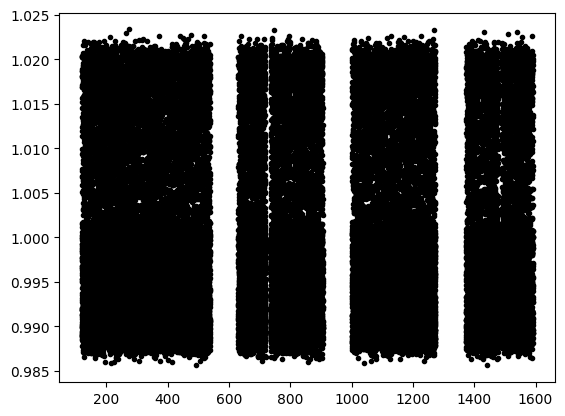

In [6]:
plt.plot(lc_fake.time.value,lc_fake.flux.value, 'k.')

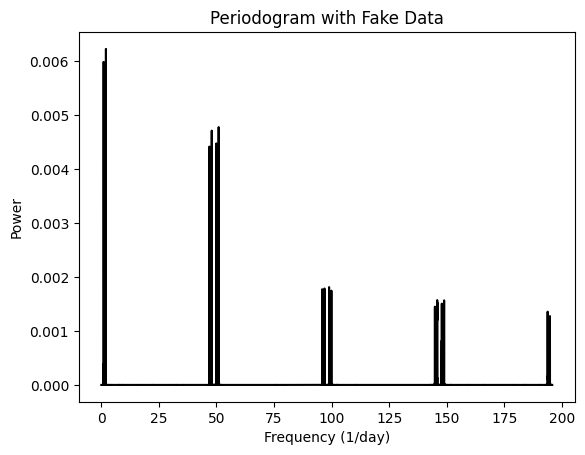

In [7]:
##using LightKurve Periodogram function, WITH DAYS!

#time is in days
f_min = delta_f/3
frequency_grid = np.arange(f_min, f_max, f_min)/(u.day)

pg_fake = lc_fake.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

fake_power = pg_fake.power.value

##IMPORTANT: when lightcurve uses to_periodogram(), it automatically converts to microhertz for some reason, so we must convert it back to days

fake_freq = pg_fake.frequency.to(1/u.day).value 
#fake_freq = pg_fake.frequency.value

plt.plot(fake_freq, fake_power,'k-')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Periodogram with Fake Data")
plt.show() 

In [8]:
print(pg_fake.power)
print(lc_fake)

[3.33928304e-08 2.97102999e-08 2.41529329e-08 ... 7.09922189e-09
 2.88855159e-09 2.57870060e-08] 1 / uHz
       time               flux        flux_err
                                              
------------------ ------------------ --------
120.53882471062389 0.9998923868552685      nan
120.55925930149533 0.9984205512884269      nan
120.57969379242422 0.9978129233906095      nan
120.60012848328915 0.9965079061291724      nan
120.62056307421881 0.9929784051642729      nan
120.64099756508949 0.9920851042971762      nan
120.66143215601187 0.9912096080307486      nan
120.68186684694228 0.9888539407552946      nan
120.70230133787118 0.9894796038875104      nan
               ...                ...      ...
1590.8171708824957 0.9967293299331197      nan
1590.8376055308108 0.9999949134441529      nan
1590.8580399792118 1.0035720925225005      nan
 1590.878474527708 1.0079793148240461      nan
1590.8989091763142  1.012169472267173      nan
1590.9193436249916 1.0137669233239412      nan
 1

In [9]:
fake_ind = nana.get_started(2, fake_freq, fake_power)
print(fake_ind)

[8822 4410]


In [10]:
x,y,second_deriv = nana.refine_peaks(fake_freq,fake_power,fake_ind)
print(x,y,second_deriv)
print(fake_freq[fake_ind[0]])

[2.00000572 0.99999427] [0.00630997 0.00623278] [-80398.21361997 -73297.10754703]
2.0000513345918676


(1.9796495868741675, 2.020453082309568)

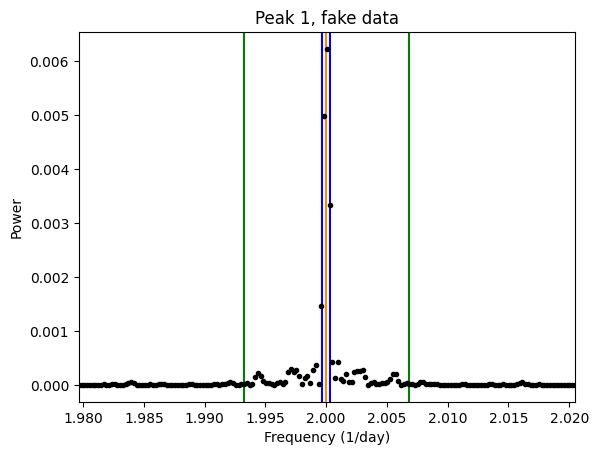

In [11]:
#Plot peak 1
plt.title("Peak 1, " + name_fake)
plt.axvline(x = x[0], color = 'darkorange')
#plt.axvline(x = fake_freq[fake_ind[0]], color = 'red')
plt.axvline(x = x[0]-delta_f/2, color = 'b')
plt.axvline(x = x[0]+delta_f/2, color = 'b')
plt.axvline(x = x[0]-10*delta_f, color = 'g')
plt.axvline(x = x[0]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(fake_freq, fake_power, 'k.')
plt.xlim(fake_freq[fake_ind[0]]-30*delta_f, fake_freq[fake_ind[0]]+30*delta_f)

(0.9795105765353573, 1.0203140719707575)

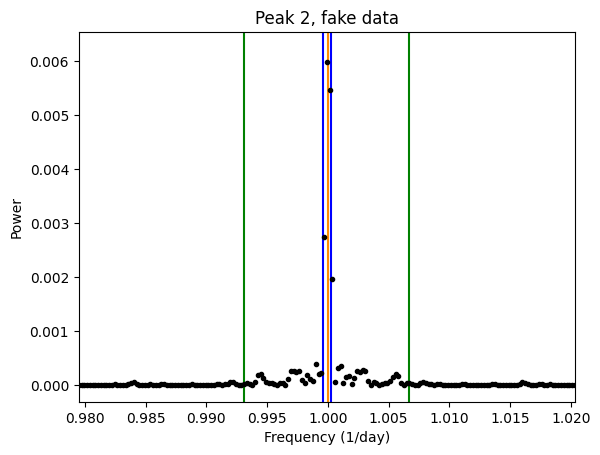

In [12]:
#Plot peak at 2
plt.title("Peak 2, " + name_fake)
#plt.axvline(x = fake_freq[fake_ind[1]], color = 'red')
plt.axvline(x = x[1], color = 'darkorange')
plt.axvline(x = fake_freq[fake_ind[1]]-delta_f/2, color = 'b')
plt.axvline(x = fake_freq[fake_ind[1]]+delta_f/2, color = 'b')
plt.axvline(x = fake_freq[fake_ind[1]]-10*delta_f, color = 'g')
plt.axvline(x = fake_freq[fake_ind[1]]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(fake_freq, fake_power, 'k.')
plt.xlim(fake_freq[fake_ind[1]]-30*delta_f, fake_freq[fake_ind[1]]+30*delta_f)

NameError: name 'refined_peaks' is not defined

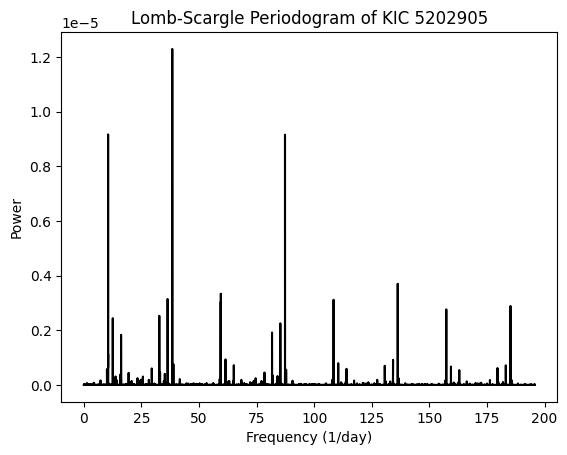

In [13]:
##Doing the same thing with real data

#time is in days


pg_real = lc.to_periodogram(
    #method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

real_power = pg_real.power.value
real_freq = pg_real.frequency.to(1/u.day).value 

plt.plot(real_freq, real_power,'k-')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.scatter(refined_peaks[0:6], y_new[0:6], color='red', marker='o', label="Detected Peaks")
plt.show() 

In [14]:
indx = nana.get_started(100,real_freq,real_power)
refined_peaks,y_new, second_derivative = nana.refine_peaks(real_freq,real_power,indx)
print(refined_peaks[0])

38.39793161036696


In [15]:
def sharpness(second_derivative, y_new, index):
    sharpness = (-second_derivative[index]/y_new[index])**(1/2)
    return sharpness

In [16]:
(-second_derivative[0]/y_new[0])**(1/2)

np.float64(3559.269614787064)

In [17]:
def median(indices, xs, ys):
    good_medians = []
    for i in indices:
        leftside = ys[i-10:i]  
        rightside = ys[i+1:i+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        good_medians.append(median)
    return np.array(good_medians)



In [18]:
medians = median(indx, real_freq, real_power)

In [19]:
print(refined_peaks[0:6])
print(0.5*refined_peaks[1]+0.5*refined_peaks[2])
print(1/sampling_rate)
print(1/(refined_peaks[5]-refined_peaks[4]))

[ 38.39793161  10.54113514  87.33700543 136.27612239  59.48022385
  59.48271053]
48.939070285565904
48.93900034783809
402.14242272044453


In [ ]:
plt.title("Real Data Peak 1")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = medians[0], color = 'r', linestyle = '--')
plt.axvline(x = refined_peaks[0], color = 'darkorange')
plt.axvline(x = refined_peaks[0]-delta_f, color = 'b')
plt.axvline(x = refined_peaks[0]+delta_f, color = 'b')
plt.axvline(x = refined_peaks[0]-10*delta_f, color = 'g')
plt.axvline(x = refined_peaks[0]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(refined_peaks[0]-30*delta_f, refined_peaks[0]+30*delta_f)
s1 = sharpness(second_derivative, y_new, 0)
print(s1)

In [ ]:
plt.title("Real Data Peak 2")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = medians[1], color = 'r', linestyle = '--')
plt.axvline(x = refined_peaks[1], color = 'darkorange')
plt.axvline(x = refined_peaks[1]-delta_f, color = 'b')
plt.axvline(x = refined_peaks[1]+delta_f, color = 'b')
plt.axvline(x = refined_peaks[1]-10*delta_f, color = 'g')
plt.axvline(x = refined_peaks[1]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(refined_peaks[1]-30*delta_f, refined_peaks[1]+30*delta_f)
s2 = sharpness(second_derivative, y_new, 1)
print(s2)

In [ ]:
#Plot Thirds Peak
plt.title("Real Data Peak 3")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = medians[2], color = 'r', linestyle = '--')
plt.axvline(x = refined_peaks[2], color = 'darkorange')
plt.axvline(x = refined_peaks[2]-delta_f, color = 'b')
plt.axvline(x = refined_peaks[2]+delta_f, color = 'b')
plt.axvline(x = refined_peaks[2]-10*delta_f, color = 'g')
plt.axvline(x = refined_peaks[2]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(refined_peaks[2]-30*delta_f, refined_peaks[2]+30*delta_f)
print(sharpness(second_derivative, y_new, 2))

In [ ]:
#Plot Fourth Peak
plt.title("Real Data Peak 4")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = medians[3], color = 'r', linestyle = '--')
plt.axvline(x = refined_peaks[3], color = 'darkorange')
plt.axvline(x = refined_peaks[3]-delta_f, color = 'b')
plt.axvline(x = refined_peaks[3]+delta_f, color = 'b')
plt.axvline(x = refined_peaks[3]-10*delta_f, color = 'g')
plt.axvline(x = refined_peaks[3]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(refined_peaks[3]-30*delta_f, refined_peaks[3]+30*delta_f)
print(sharpness(second_derivative, y_new, 3))

In [ ]:
#Plot Fifth Peak
plt.title("Real Data Peak 5")
plt.axhline(y = 0., color='k', lw=1)
plt.axhline(y = medians[4], color = 'r', linestyle = '--')
plt.axvline(x = refined_peaks[4], color = 'darkorange')
plt.axvline(x = refined_peaks[4]-delta_f, color = 'b')
plt.axvline(x = refined_peaks[4]+delta_f, color = 'b')
plt.axvline(x = refined_peaks[4]-10*delta_f, color = 'g')
plt.axvline(x = refined_peaks[4]+10*delta_f, color = 'g')
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.plot(real_freq, real_power, 'k.')
plt.xlim(refined_peaks[4]-30*delta_f, refined_peaks[4]+30*delta_f)
print(sharpness(second_derivative, y_new, 4))

In [ ]:
##thresholdfunction parameters for now 10deltaf around peak must be greater than 5*median
#T^2 must be greater than total observation time(about 1400 days) (second derivative parameter)
#returns indices of the peaks that pass threshold

def threshold(indices, xs, ys):
    good_peaks = []
    for i in range(len(indices)):
        leftside = ys[indices[i]-10:indices[i]]  
        rightside = ys[indices[i]+1:indices[i]+11]
        median = np.nanmedian(np.concatenate((leftside,rightside)))
        if (ys[indices[i]] > 5*median) and (-second_derivative[i]/(y_new[i]))**(1/2) > total_observation_time:
            good_peaks.append(indices[i])

    return np.array(good_peaks)

In [ ]:
good_peaks_test = threshold(indx, real_freq, real_power)
print(good_peaks_test)

In [ ]:
print(len(good_peaks_test))

In [ ]:
##characertization
#erin 